<a href="https://colab.research.google.com/github/DmitrijLeontev/Dmitrij_Leontev/blob/main/%D1%81%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B8%20/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%B2%D0%B5%D0%B4%D1%83%D1%89%D0%B8%D0%B9_%D0%9A%D0%9F_%D0%9D%D0%B0_%D0%B7%D0%B0%D0%BA%D0%B0%D1%82%D0%B5/cod%D0%A1%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%B2%D0%B5%D0%B4%D1%83%D1%89%D0%B8%D0%B9_%D0%9A%D0%9F_(%D0%94%D0%97Pro6(9)%D0%B7%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5ChatGPTPro).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Целью данного проекта является разработка и интеграция искусственного интеллекта (ИИ) на базе ChatGPT для участия в телевизионной программе "На Закате" в роли ведущего. ИИ должен быть способен вести беседу с настоящими ведущими и отвечать на их вопросы, создавая естественную и непринужденную атмосферу для зрителей.  Выведите гистограммы распределения длин чанков. Получите ответы нейро-ведущего на представленной БЗ(вводный документ)+ самаризированный диалог.

Тест проведем на основе русской сказки  А. С. Пушкина Сказка о царе Салтане:-)
 Cсылк на ДБ: "https://docs.google.com/document/d/1bFBdxhVVVGzPvMp0YcunAi_8LGxJYr34z3a_kmL6o4Q/edit?usp=sharing"

In [ ]:
# Установка необходимых библиотек
!pip install faiss-cpu langchain==0.0.271 openai tiktoken

In [ ]:
pip install langchain==0.0.271


In [ ]:
!pip install --upgrade openai

In [ ]:
import openai

# ... (other imports)

try:
    # Your OpenAI API calls or other code
    pass  # Placeholder for the code inside the try block
except openai.error.OpenAIError as e:
    print(f"An error occurred: {e}")

In [ ]:
import os
import getpass
import matplotlib.pyplot as plt
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage
import re
import tiktoken
import requests
from openai import Error as OpenAIError  # Используем OpenAIError вместо error
from langchain.docstore.document import Document

ImportError: ignored

In [ ]:
openai_key = getpass.getpass("OpenAI API Key:")
os.environ["OPENAI_API_KEY"] = openai_key
openai.api_key = openai_key

OpenAI API Key:··········


In [ ]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [ ]:
# База знаний, которая будет подаваться в langChain
database= load_document_text('https://docs.google.com/document/d/1bFBdxhVVVGzPvMp0YcunAi_8LGxJYr34z3a_kmL6o4Q/edit?usp=sharing')   # заполните необходимым значением, база данных

In [ ]:
database[:1000]

'\ufeffСказка о царе Салтане\r\nТри девицы под окном\r\nПряли поздно вечерком.\r\n«Кабы я была царица, —\r\nГоворит одна девица, —\r\nТо на весь крещеный мир\r\nПриготовила б я пир».\r\n«Кабы я была царица, —\r\nГоворит ее сестрица, —\r\nТо на весь бы мир одна\r\nНаткала я полотна».\r\n«Кабы я была царица, —\r\nТретья молвила сестрица, —\r\nЯ б для батюшки-царя\r\nРодила богатыря».\r\nТолько вымолвить успела,\r\nДверь тихонько заскрыпела,\r\nИ в светлицу входит царь,\r\nСтороны той государь.\r\nВо всё время разговора\r\nОн стоял позадь забора;\r\nРечь последней по всему\r\nПолюбилася ему.\r\n«Здравствуй, красная девица, —\r\nГоворит он, — будь царица\r\nИ роди богатыря\r\nМне к исходу сентября.\r\nВы ж, голубушки-сестрицы,\r\nВыбирайтесь из светлицы,\r\nПоезжайте вслед за мной,\r\nВслед за мной и за сестрой:\r\nБудь одна из вас ткачиха,\r\nА другая повариха».\r\nВ сени вышел царь-отец.\r\nВсе пустились во дворец.\r\nЦарь недолго собирался:\r\nВ тот же вечер обвенчался.\r\nЦарь Салтан з

In [ ]:
# предобработаем текст таким образом, чтобы его можно было бы поделить на чанки при помощи MarkdownHeaderTextSplitter
def text_to_markdown(text):
    # Добавляем заголовок 1 уровня на основе римских чисел (без переноса строки)
    # и дублируем его строчкой ниже - иначе эта информация перенесется в метаданные, а порой она бывает полезной.
    def replace_header1(match):
        return f"# {match.group(2)}\n{match.group(2)}"
    '''Далее используем функцию re.sub из модуля регулярных выражений re для замены подстрок в строке text.
    Шаблон регулярного выражения (I{1,3}|IV|V)\. (.+) ищет римские числа от I до V в начале строки, за которыми следует точка и пробел.
    Функция replace_header1 вызывается для каждого совпадения, и ее возвращаемое значение используется для замены найденной подстроки.
    Флаг re.M позволяет ^ соответствовать началу каждой строки, а не только началу всего текста.'''
    text = re.sub(r'^(I{1,3}|IV|V)\. (.+)', replace_header1, text, flags=re.M)

    # Добавляем текст, выделенный жирным шрифтом (он заключен между *)
    # и дублируем его строчкой ниже
    def replace_header2(match):
        return f"## {match.group(1)}\n{match.group(1)}"

    text = re.sub(r'\*([^\*]+)\*', replace_header2, text)

    return text

In [ ]:
markdown = text_to_markdown(database)                 # заполните необходимым значением
print(markdown[:30000])

﻿Сказка о царе Салтане
Три девицы под окном
Пряли поздно вечерком.
«Кабы я была царица, —
Говорит одна девица, —
То на весь крещеный мир
Приготовила б я пир».
«Кабы я была царица, —
Говорит ее сестрица, —
То на весь бы мир одна
Наткала я полотна».
«Кабы я была царица, —
Третья молвила сестрица, —
Я б для батюшки-царя
Родила богатыря».
Только вымолвить успела,
Дверь тихонько заскрыпела,
И в светлицу входит царь,
Стороны той государь.
Во всё время разговора
Он стоял позадь забора;
Речь последней по всему
Полюбилася ему.
«Здравствуй, красная девица, —
Говорит он, — будь царица
И роди богатыря
Мне к исходу сентября.
Вы ж, голубушки-сестрицы,
Выбирайтесь из светлицы,
Поезжайте вслед за мной,
Вслед за мной и за сестрой:
Будь одна из вас ткачиха,
А другая повариха».
В сени вышел царь-отец.
Все пустились во дворец.
Царь недолго собирался:
В тот же вечер обвенчался.
Царь Салтан за пир честной
Сел с царицей молодой;
А потом честные гости
На кровать слоновой кости
Положили молодых
И оставили одни

In [ ]:
# Инструкция в system
system = load_document_text('https://docs.google.com/document/d/1vmlu1DXhg48ltJBf9lvCraUi8TWNQ-gBmh1tRKv1eXQ/edit?usp=sharing') # заполните параметр ссылкой на составленный вами промпт. Не забудьте открыть доступ

In [ ]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

def split_text(text, max_count):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    # Подсчет токенов для каждого фрагмента и построение графика
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    plt.hist(fragment_token_counts, bins=20, alpha=0.5, label='Fragments')
    plt.title('Distribution of Fragment Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_count,
        chunk_overlap=0,
        length_function=lambda x: num_tokens_from_string(x, "cl100k_base")
    )

    source_chunks = [
        Document(page_content=chunk, metadata=fragment.metadata)
        for fragment in fragments
        for chunk in splitter.split_text(fragment.page_content)
    ]

    # Подсчет токенов для каждого source_chunk и построение графика
    source_chunk_token_counts = [num_tokens_from_string(chunk.page_content, "cl100k_base") for chunk in source_chunks]
    plt.hist(source_chunk_token_counts, bins=20, alpha=0.5, label='Source Chunks')
    plt.title('Distribution of Source Chunk Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    return source_chunks

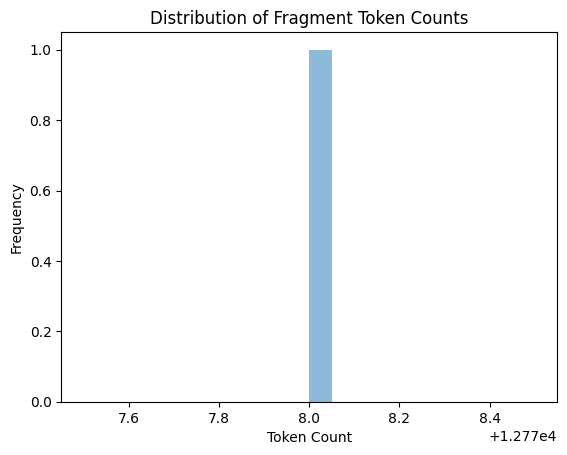

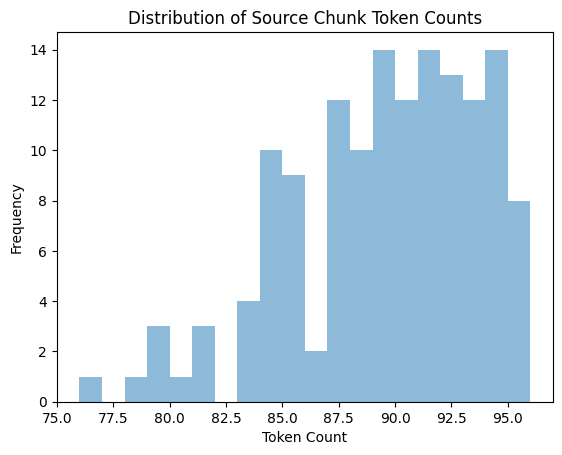

Общее количество чанков:  143
Первый чанк  page_content='\ufeffСказка о царе Салтане\nТри девицы под окном\nПряли поздно вечерком.\n«Кабы я была царица, —\nГоворит одна девица, —\nТо на весь крещеный мир\nПриготовила б я пир».' metadata={}


In [ ]:
source_chunks = split_text(database, 100)                          # заполните необходимыми значениями
print("Общее количество чанков: ",len(source_chunks))
print("Первый чанк ", source_chunks[0])

In [ ]:
import os
import getpass
import matplotlib.pyplot as plt
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage
import re
import tiktoken
import requests
from openai import Error as OpenAIError  # Используем OpenAIError вместо error
from langchain.docstore.document import Document

# Установка необходимых библиотек
!pip install faiss-cpu langchain==0.0.271 openai tiktoken

# Установка OpenAI
!pip install --upgrade openai

# Введите ваш ключ OpenAI API
openai_key = getpass.getpass("OpenAI API Key:")
os.environ["OPENAI_API_KEY"] = openai_key
openai.api_key = openai_key

# Загрузка текста документа по ссылке из Google Диска
def load_document_text(url: str) -> str:
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text
    return text

# База знаний
database_url = 'https://docs.google.com/document/d/1bFBdxhVVVGzPvMp0YcunAi_8LGxJYr34z3a_kmL6o4Q/edit?usp=sharing'
database = load_document_text(database_url)

# Функция для преобразования текста в формат Markdown
def text_to_markdown(text):
    # Реализация вашей функции text_to_markdown
    # ...

# Предобработка текста
markdown = text_to_markdown(database)

# Инструкция в system
system_url = 'https://docs.google.com/document/d/1vmlu1DXhg48ltJBf9lvCraUi8TWNQ-gBmh1tRKv1eXQ/edit?usp=sharing'
system = load_document_text(system_url)

# Получение чанков из предобработанного текста
def split_text(text, max_count):
    # Реализация вашей функции split_text
    # ...

# Получение токенов из строки
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    # Реализация вашей функции num_tokens_from_string
    # ...

# Сплиттер и получение чанков
source_chunks = split_text(markdown, 100)

# Инициализация модели эмбеддингов
embeddings = OpenAIEmbeddings()

# Получение самой модели из embeddings
model = embeddings._embedder.model if hasattr(embeddings, "_embedder") and hasattr(embeddings._embedder, "model") else None

# Создание индекса из разделенных фрагментов текста
try:
    db = FAISS.from_documents(source_chunks, model)
except AttributeError:
    # Если произошла ошибка AttributeError, попробуем обратиться к _model напрямую
    model = embeddings._model if embedder_model is None else embedder_model
    db = FAISS.from_documents(source_chunks, model)

# Ваш код дальше...



IndentationError: ignored

In [ ]:
def insert_newlines(text: str, max_len: int = 170) -> str:
    """
    Функция разбивает длинный текст на строки определенной максимальной длины.
    """
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line + " " + word) > max_len:
            lines.append(current_line)
            current_line = ""
        current_line += " " + word
    lines.append(current_line)
    return "\n".join(lines)

In [ ]:
def answer_index(system, topic, search_index, temp=0, verbose=0) -> str:
    """
    Функция возвращает ответ модели на основе заданной темы.
    """
    # находим наиболее релевантные вопросу пользователя чанки:
    docs_with_score = search_index.similarity_search_with_score(topic, k=4)

    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, (doc, score) in enumerate(docs_with_score)]))

    # если параметр verbose=1, то выводим релевантные чанки
    if verbose:
        print('message_content :\n', message_content)

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Документ с информацией для ответа пользователю: {message_content}\n\nВопрос пользователя: \n{topic}"}
    ]

    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-16k",
        messages=messages,
        temperature=temp
    )

    return insert_newlines(completion.choices[0].message.content)

In [ ]:
def summarize_questions(dialog):
    """
    Функция возвращает саммаризированный текст диалога.
    """
    messages = [
        {"role": "system", "content": "Ты - нейро-саммаризатор. Твоя задача - саммаризировать диалог, который тебе пришел. Если пользователь назвал свое имя, обязательно отрази его в саммаризированном диалоге"},
        {"role": "user", "content": "Саммаризируй следующий диалог консультанта и пользователя: " + " ".join(dialog)}
    ]

    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",     # используем gpt3.5 для более точной саммаризации
        messages=messages,
        temperature=0,          # Используем более низкую температуру для более определенной суммаризации
    )

    return completion.choices[0].message.content

In [ ]:
def answer_user_question_dialog(system, db, user_question, question_history):
    """
    Функция возвращает ответ на вопрос пользователя.
    """
    summarized_history = ""
    # Если в истории более одного вопроса, применяем суммаризацию
    if len(question_history) > 0:
        summarized_history = "Вот краткий обзор предыдущего диалога: " + summarize_questions([q + ' ' + (a if a else '') for q, a in question_history])

    # Добавляем явное разделение между историей диалога и текущим вопросом
    input_text = summarized_history + "\n\nТекущий вопрос: " + user_question

    # Извлекаем наиболее похожие отрезки текста из базы знаний и получение ответа модели
    answer_text = answer_index(system, input_text, db)

    # Добавляем вопрос пользователя и ответ системы в историю
    question_history.append((user_question, answer_text if answer_text else ''))

    # Выводим саммаризированный текст, который видит модель
    if summarized_history:
        print('****************************')
        print(insert_newlines(summarized_history))
        print('****************************')

    return insert_newlines(answer_text)

In [ ]:
def run_dialog(system_doc_url, knowledge_base_url):
    """
    Функция запускает диалог между пользователем и нейро-консультантом.
    """
    #список кортежей, где каждый кортеж содержит пару вопрос-ответ, для отслеживания истории вопросов и ответов во время сессии диалога.
    question_history = []
    while True:
        user_question = input('Пользователь: ')
        if user_question.lower() == 'stop':
            break
        answer = answer_user_question_dialog(system_doc_url, knowledge_base_url, user_question, question_history)
        print('Консультант:', answer)

    return

In [ ]:
# проверьте работу нейро-консультанта на нескольких самостоятельно сгенерированных вопросах. Проверьте, что соблюдаются инструкции и поддерживается диалог
run_dialog(system, db)

NameError: ignored